In [1]:
import sys
import os
from tqdm import tqdm
import random
import numpy as np
import math
# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

sys.path.append(parent_dir)

#import simtrain
from simtrain.sim_models_new import User_simmulation_Model, Conditioned_User_simmulation_Model, Toy_intensity_Comparer, all_in_one_model

from simtrain import SETTINGS_POLIMI as SETTINGS
from simtrain import explore_models, process_dat
from simtrain.train import train_function_approx_multiple_variational, train_density_multiple_variational_sorted

import simtrain.utils as utils
from simtrain.Dataset import CustomDataset, TimestepFrequencyDataset
from simtrain.train import train, train_with_negatives

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

import ast

import paths
from os.path import join
import pytorch_warmup as warmup
from functools import partial
import torch.optim as optim
import matplotlib.pyplot as plt


In [2]:
#num_items = 7
#num_items_per_recom = 2
num_interaction_types = 2
recom_dim = 1
#num_users = 11
#min_inter = 2
#max_inter = 4
state_size = SETTINGS.STATE_SIZE
subset = 2 # make data smaller
experiment_name = "intensity"
num_negatives = 150
conditioned=False
kl_weight=.01
state_size

4

# Data

## old

In [3]:
#create dataset from processed data
if True:
    train_dat, stg = process_dat.load_dat(paths.cw_stages['output_new']['train'], new_data=True)

    print(stg)

    def convert_string_to_double_list(s):
        return ast.literal_eval(s)

    # Apply the custom function
    train_dat['item_ids'] = train_dat['item_ids'].apply(convert_string_to_double_list)
    train_dat['user_means'] = train_dat['user_means'].apply(convert_string_to_double_list)
    train_dat['user_vars_log'] = train_dat['user_vars_log'].apply(convert_string_to_double_list)
    train_dat['timestamps'] = train_dat['timestamps'].apply(convert_string_to_double_list)
    train_dat['interaction_types'] = train_dat['interaction_types'].apply(convert_string_to_double_list)

    print("len: ", len(train_dat))
    list_of_dicts = train_dat.to_dict(orient='records')
    list_of_dicts = list_of_dicts[:subset]
    train_dat.head()


{'NI': 14, 'NU': 328, 'T': '[9.708333333333334, 12.4375, 12.604166666666666, 13.395833333333334, 15.458333333333334, 15.979166666666666, 17.333333333333332, 18.6875, 20.58333333333333, 21.354166666666668, 21.375, 21.39583333333333, 21.416666666666668, 21.4375, 21.45833333333333, 21.479166666666668, 22.52083333333333, 24.39583333333333, 24.416666666666668, 24.4375, 24.45833333333333, 24.479166666666668, 24.5, 24.52083333333333, 25.479166666666668, 25.5, 25.52083333333333, 25.541666666666668, 25.58333333333333, 25.64583333333333, 29.33333333333333, 30.14583333333333, 30.58333333333333, 30.604166666666668, 30.625, 30.979166666666668, 32.0, 34.354166666666664, 36.66666666666666, 36.6875, 37.5625, 37.583333333333336, 38.583333333333336, 43.10416666666666, 43.333333333333336]', 'NS': 100, 'INF_TIME': 1000}
len:  328


In [4]:
#checkpoint = torch.load(join(paths.dat, SETTINGS.rootpaths['models'],
#                             experiment_name, "data.h5"))
#list_of_dicts = checkpoint['data']

In [5]:

def adjust_hidden_dim(data_dict, state_size):
    # just to jumstart experiments should be deleted at the end
    for row in data_dict:
        if row["user_means"] > state_size:
            row["user_means"] = row["user_means"][:state_size]
            row["user_vars_log"] = row["user_vars_log"][:state_size]
        elif row["user_means"] > state_size:
            pass# dont care

#adjust_hidden_dim(list_of_dicts, state_size)

In [6]:
dataset = CustomDataset(list_of_dicts[:subset]) # [:30]

dataloader = DataLoader(dataset, batch_size=1, shuffle=True)# can only do batchsize 1

In [7]:
def test_data(dataloader):
    smallest = float("inf")
    biggest = -1
    count_classes = [0 for _ in range(num_interaction_types)]
    for batch in dataloader:
        timestamps, items, labels, means, var, idx = batch
        last = timestamps[0]
        smallest = min(smallest, last)
        biggest = max(biggest, timestamps[-1])
        for i in range(1,len(timestamps)):
            if timestamps[i] <= last:
                print("error, current: ", timestamps[i], "\tlast", last)
        
        for i in range(num_interaction_types):
            for row in labels:
                row=torch.as_tensor(row)
                count = torch.sum(row == i)
                count_classes[i] += count

    smallest, biggest= int(smallest), float(biggest)
    print(smallest), print(biggest)
    for i in range(num_interaction_types):
        print(f"number of interactions of type {i} = {count_classes[i]}")
    return biggest

max_time = test_data(dataloader)

5
69.33333333333333
number of interactions of type 0 = 5955
number of interactions of type 1 = 10


In [8]:
'''
for batch in dataloader:
    timestamps, items, labels, means, var, idx = batch
    print('Timestamps:', timestamps#, "\n dtype: ", timestamps.dtype
          )
    print('item_recom:', items#, "\n dtype: ", items.dtype
          )
    print('Labels:', labels#, "\n dtype: ", labels.dtype
          )
    print('means:', means#, "\n dtype: ", means.dtype
          )
    print('log_var:', var#, "\n dtype: ", var.dtype
          )
    break
    '''

'\nfor batch in dataloader:\n    timestamps, items, labels, means, var, idx = batch\n    print(\'Timestamps:\', timestamps#, "\n dtype: ", timestamps.dtype\n          )\n    print(\'item_recom:\', items#, "\n dtype: ", items.dtype\n          )\n    print(\'Labels:\', labels#, "\n dtype: ", labels.dtype\n          )\n    print(\'means:\', means#, "\n dtype: ", means.dtype\n          )\n    print(\'log_var:\', var#, "\n dtype: ", var.dtype\n          )\n    break\n    '

## new data

In [ ]:
train_sorted = False
batchsize = 64  # needs to be 1 for ode
centered_intervals = False

In [ ]:
#create dataset from processed data
if True:
    train_dat, stg = process_dat.load_dat(paths.cw_stages['output_new']['train'], new_data=True)

    print(stg)

    def convert_string_to_double_list(s):
        return ast.literal_eval(s)

    # Apply the custom function
    train_dat['item_ids'] = train_dat['item_ids'].apply(convert_string_to_double_list)
    train_dat['user_means'] = train_dat['user_means'].apply(convert_string_to_double_list)
    train_dat['user_vars_log'] = train_dat['user_vars_log'].apply(convert_string_to_double_list)
    train_dat['timestamps'] = train_dat['timestamps'].apply(convert_string_to_double_list)
    train_dat['interaction_types'] = train_dat['interaction_types'].apply(convert_string_to_double_list)

    print("len: ", len(train_dat))
    list_of_dicts = train_dat.to_dict(orient='records')
    list_of_dicts = list_of_dicts[:subset]
    train_dat.head()


{'NI': 14, 'NU': 328, 'T': '[9.708333333333334, 12.4375, 12.604166666666666, 13.395833333333334, 15.458333333333334, 15.979166666666666, 17.333333333333332, 18.6875, 20.58333333333333, 21.354166666666668, 21.375, 21.39583333333333, 21.416666666666668, 21.4375, 21.45833333333333, 21.479166666666668, 22.52083333333333, 24.39583333333333, 24.416666666666668, 24.4375, 24.45833333333333, 24.479166666666668, 24.5, 24.52083333333333, 25.479166666666668, 25.5, 25.52083333333333, 25.541666666666668, 25.58333333333333, 25.64583333333333, 29.33333333333333, 30.14583333333333, 30.58333333333333, 30.604166666666668, 30.625, 30.979166666666668, 32.0, 34.354166666666664, 36.66666666666666, 36.6875, 37.5625, 37.583333333333336, 38.583333333333336, 43.10416666666666, 43.333333333333336]', 'NS': 100, 'INF_TIME': 1000}
len:  328


In [ ]:
# create dataset

dataloader_list = []
#steps_per_epoch = 0 

for user in list_of_dicts:
    timestamps = user["timestamps"]
    means, logvars = user["user_means"], user["user_vars_log"]
    extras = {"user_id":user["user_id"]}
    #print(user["user_id"])
    reaction_ratio = [np.mean(np.array(row)) for row in user["interaction_types"]]
    dataset_for_user = TimestepFrequencyDataset(timestamps, num_random_points=num_negatives, 
                            reaction_ratio=reaction_ratio)

    dataloader = DataLoader(dataset_for_user, batch_size=batchsize, shuffle=not train_sorted
                        )
    dataloader_list.append([dataloader, means, logvars, extras])
    #steps_per_epoch += len(dataset) // batchsize  
    #if len(dataset) % batchsize != 0:
    #    steps_per_epoch += 1
steps_per_epoch = 64# for 64b 80u, for 16b 20u: 221, for 64b u20: 63, 

if batchsize==1 and train_sorted:
    steps_per_epoch = 20
steps_per_epoch

save interaction ratios
save interaction ratios
save interaction ratios
save interaction ratios
save interaction ratios
save interaction ratios
save interaction ratios
save interaction ratios
save interaction ratios
save interaction ratios
save interaction ratios
save interaction ratios
save interaction ratios
save interaction ratios
save interaction ratios
save interaction ratios
save interaction ratios
save interaction ratios
save interaction ratios
save interaction ratios


64

In [ ]:
sum(len(data[0]) for data in dataloader_list)

63

In [ ]:
ids= [188,491,561,670,749,800,879,931,1372,1480,1622,2118,2249,2290,2725,2808,2839,2905,2920, 3059]

In [ ]:
path_list = []
for user in list_of_dicts:
    timestamps = user["timestamps"]
    means, logvars = user["user_means"], user["user_vars_log"]
    reaction_ratio = [np.mean(np.array(row)) for row in user["interaction_types"]]
    extras = {"user_id":user["user_id"]}
    path_list.append([user["timestamps"], means, logvars, reaction_ratio, extras])

# model

## Density

In [ ]:
width = 64
model_type = "simple"
use_variational_nn = True
state_consistancy_training = False
use_jump = False
timecheat = False

intensity = {"model_hyp": {"layer_width": [width for _ in range(3)],
                           "bayesian": use_variational_nn,
                           }}
state_dict = {"model_hyp": {"layer_width": [width for _ in range(4)],
                            "noise": 0, "bayesian": use_variational_nn,},
            }
jump_dict= {"model_hyp": {"layer_width": [8, 8]}
            }
hyperparameter_dict = {"state_size": state_size, "state_model": state_dict, 
        "intensity_model": intensity, "state_model_type": model_type, # simple
        #"jump_model": jump_dict,
        "time_embedding_size" :32, "max_freq": 30,
        }
if use_jump:
 hyperparameter_dict["jump_model"] =jump_dict
model = Toy_intensity_Comparer(hyperparameter_dict)
print(model)

bayesian
bayesian
Toy_intensity_Comparer(
  (embed): SignWaveEmbedding()
  (user_state_model): Base_Model(
    (model): Sequential(
      (0): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=37, out_features=64, bias=True)
      (1): SiLU()
      (2): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=64, out_features=64, bias=True)
      (3): SiLU()
      (4): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=64, out_features=64, bias=True)
      (5): SiLU()
      (6): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=64, out_features=64, bias=True)
      (7): SiLU()
      (8): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=64, out_features=4, bias=True)
    )
  )
  (intensity_model): User_State_Intensity_Model_simple(
    (model): Sequential(
      (0): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=4, out_features=64, bias=True)
      (1): SiLU()
      (2): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=64, out_features=64, bias=True)
      (3): SiLU()

In [ ]:
from simtrain.utils import weighted_mse_loss
from simtrain.train import train_density_multiple_variational

loss = partial(weighted_mse_loss, weight_pos=10)
loss_func_kl=partial(utils.kl_divergence, mu2=0, sigma2=0.01)

In [ ]:
num_epochs = 201
warmup_period = steps_per_epoch
num_steps = num_epochs*steps_per_epoch - warmup_period
num_iter_til_first_restart = (num_steps + 1)//2
# restarts seem to ne be great most of the time here
user_lr = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

optimizer = optim.AdamW(model.parameters(), lr=user_lr,
                        weight_decay=1e-10)
lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=num_iter_til_first_restart, T_mult=1, eta_min=1e-5)

warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)
num_iter_til_first_restart

Using device: cpu


6400

In [ ]:
if train_sorted:
    train_density_multiple_variational_sorted(model, dataloader_list, criterion=weighted_mse_loss, 
            state_size=state_size, user_lr_decay=0.995, train_bayesian_weight= 0.1,
            optimizer=optimizer, num_epochs=num_epochs, warmup_scheduler=warmup_scheduler,
            loss_func_kl=loss_func_kl, kl_weight=kl_weight, user_lr=.02, device=device, 
            loss_print_interval=25, warmup_period=warmup_period, lr_scheduler=lr_scheduler,
            logging_shift = 1, model_type=model_type, use_jump=use_jump)
else:
    results =train_density_multiple_variational(model, dataloader_list, criterion=weighted_mse_loss, 
            state_size=state_size, user_lr_decay=0.995, train_bayesian_weight= 0.1,
            state_consistancy_training=state_consistancy_training, consistancy_weight=.5,
            optimizer=optimizer, num_epochs=num_epochs, warmup_scheduler=warmup_scheduler,
            loss_func_kl=loss_func_kl, kl_weight=kl_weight, user_lr=.02, device=device, 
            loss_print_interval=25, warmup_period=warmup_period, lr_scheduler=lr_scheduler,
            logging_shift = 1)


  0%|          | 0/201 [00:00<?, ?it/s]/home/thahit/github/Recommender_Sim/simtrain/train.py:506: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).to(device), torch.tensor(variational_logvar, requires_grad=True).to(device)
/home/thahit/anaconda3/envs/WWcopy/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:1360: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 1/201 [00:00<02:42,  1.23it/s]

epoch: 2 loss_sum_all: 16457.181, loss_sum_freq: 12347.019, loss_sum_kl: 4108.112, loss_state_consistancy: 0.000, lr: 0.0010000, userlr: 0.0200000


  7%|▋         | 15/201 [00:07<01:31,  2.04it/s]


KeyboardInterrupt: 

In [ ]:
cycycyc

NameError: name 'cycycyc' is not defined

### visualization

1480
area: 19.996653900146484


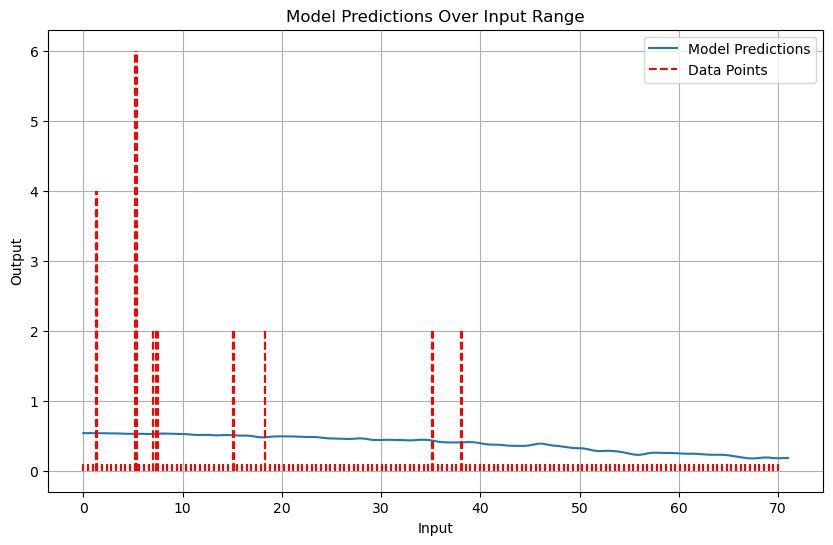

In [ ]:
# 11, 10, 4, 0, 13, 15
# good ones: 4=491? , 13=2290, 
selected_user = 3
utils.generate_density_plot(selected_user, model, model_type, dataloader_list, 
            use_variational_nn=False, train_sorted=False)

2808
area: 13.123995666503905


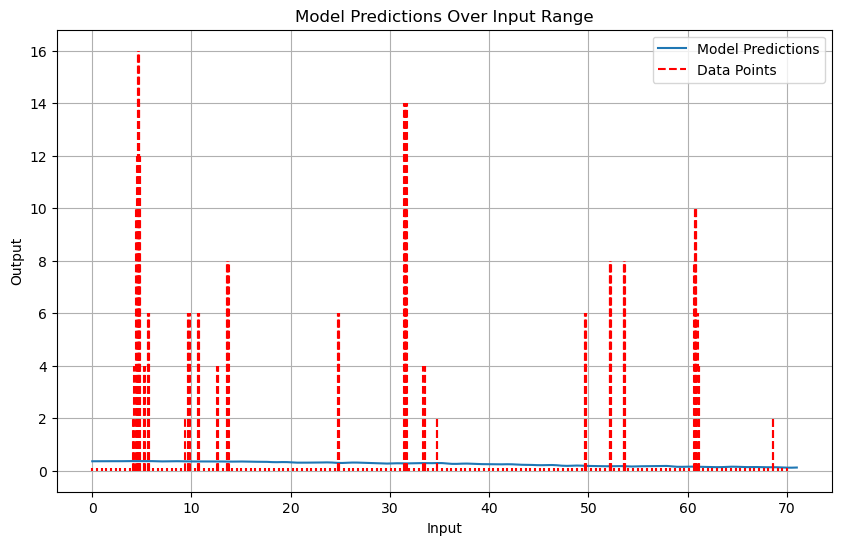

2920
area: 20.422376861572264


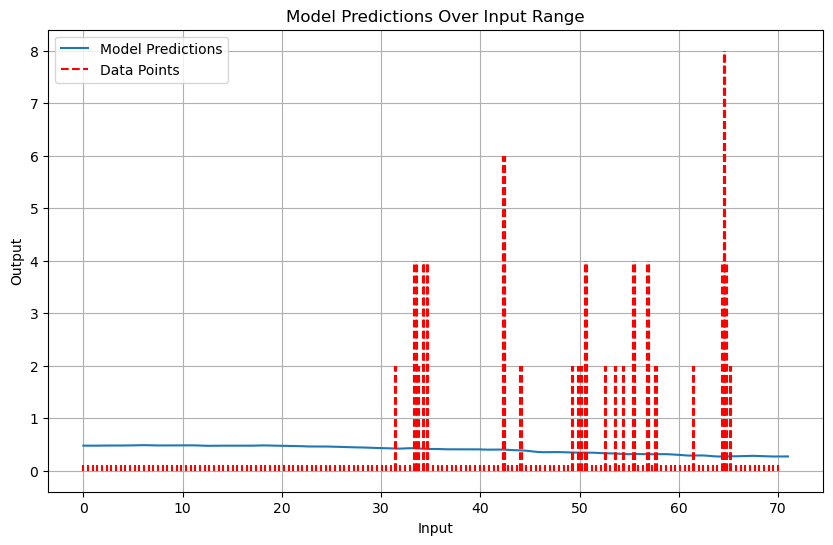

2725
area: 19.72144088745117


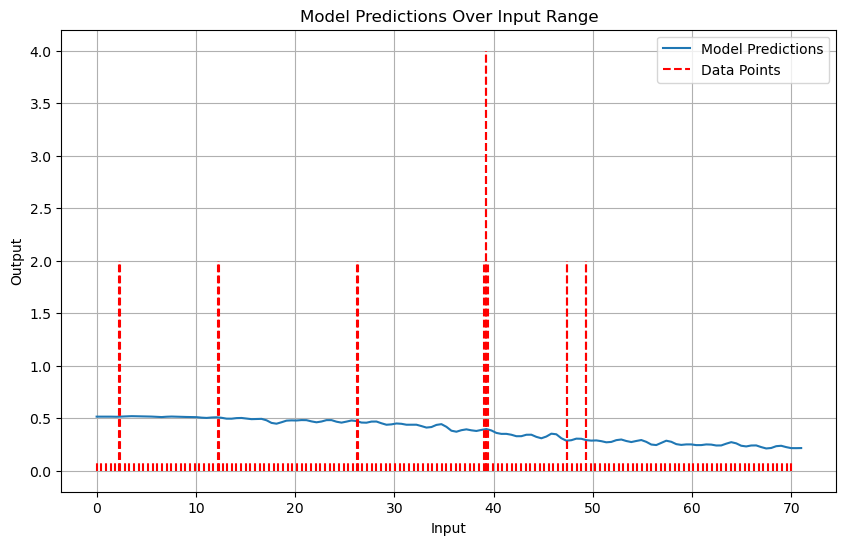

1480
area: 18.499059448242186


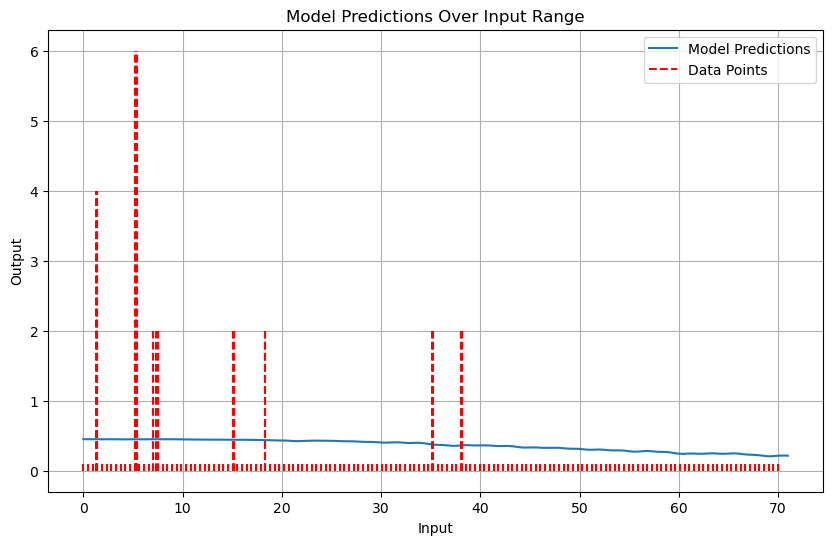

491
area: 14.00130615234375


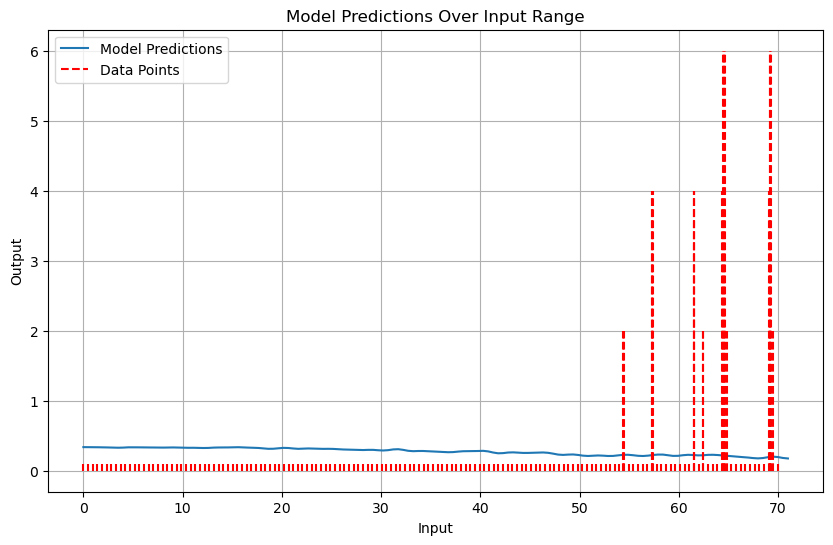

188
area: 13.677721710205077


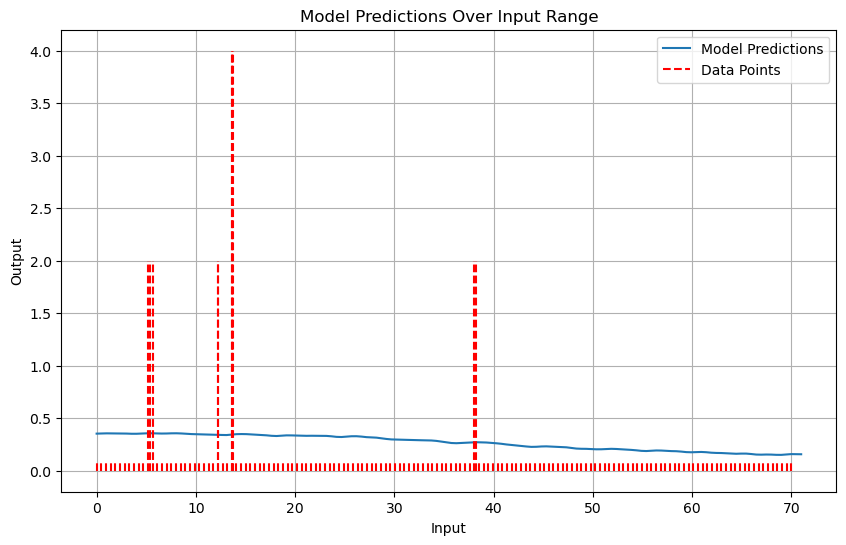

670
area: 15.753409881591796


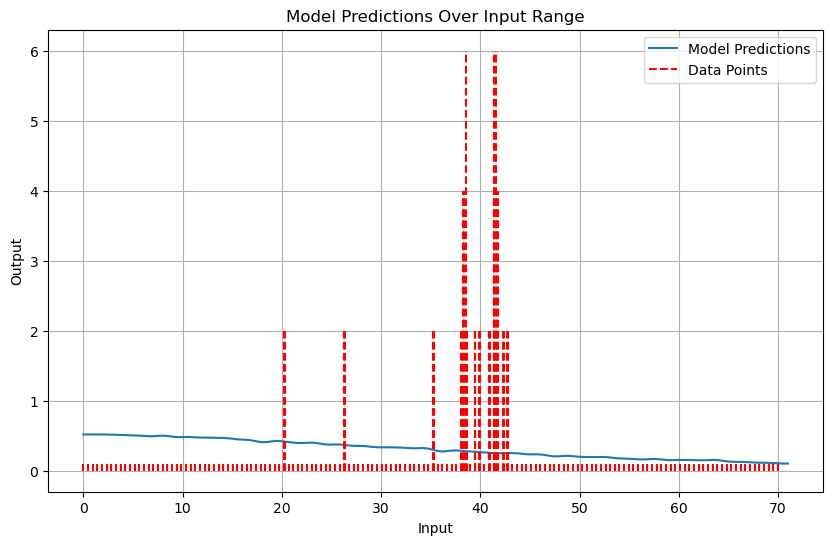

2118
area: 19.382899932861328


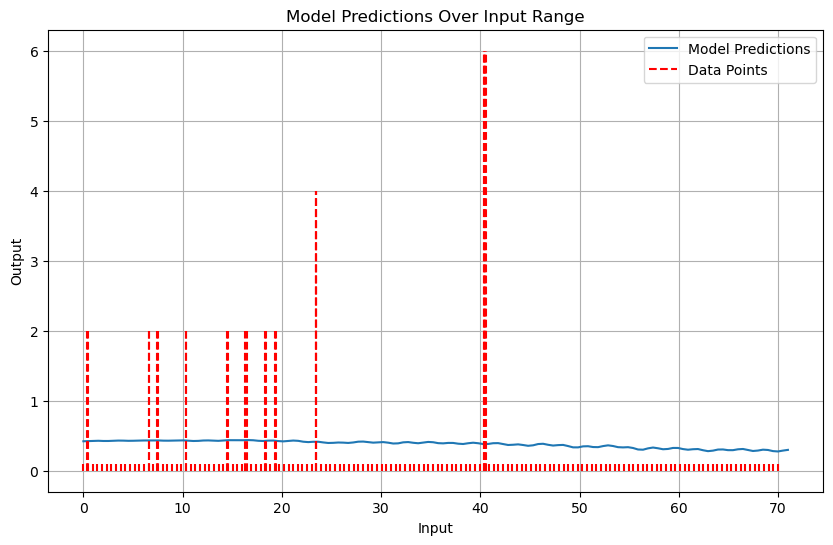

879
area: 20.656027221679686


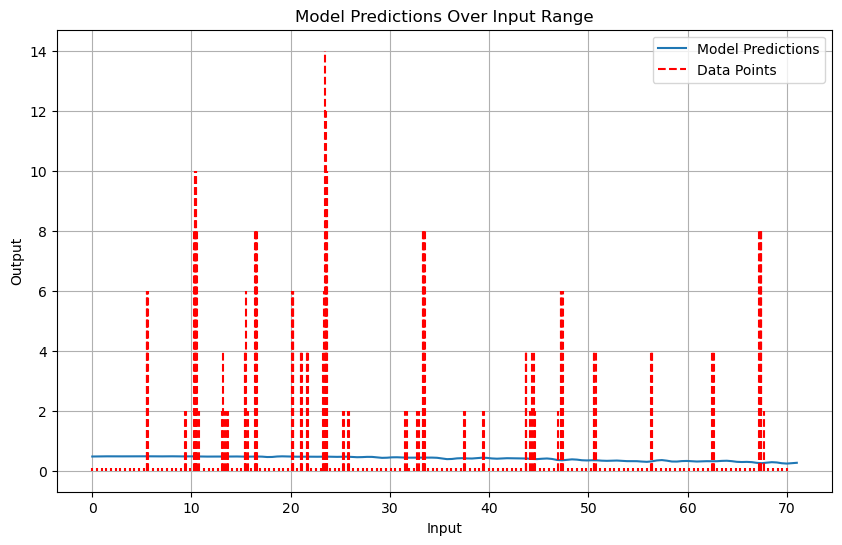

931
area: 12.916516113281249


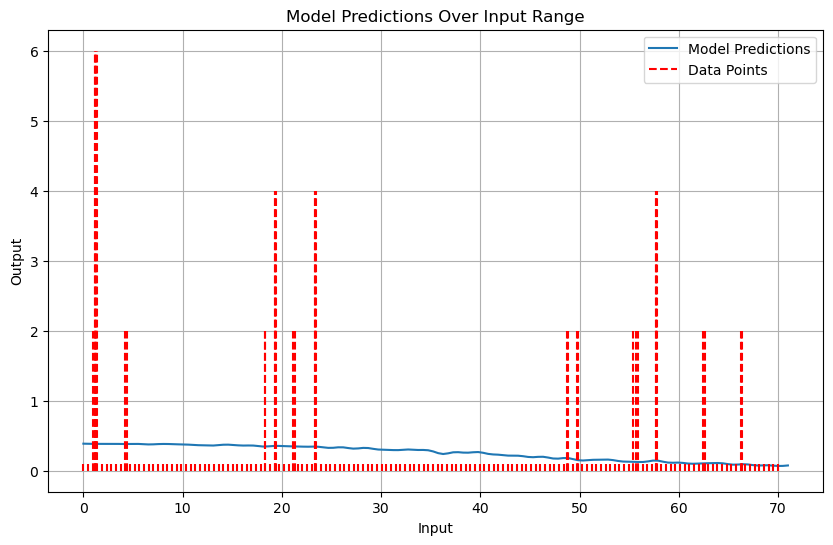

749
area: 20.454697265625


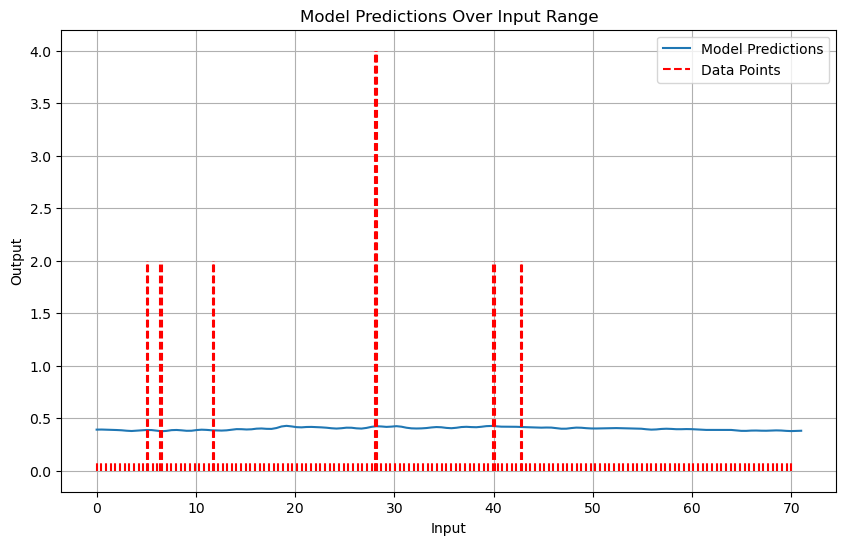

800
area: 10.449152297973633


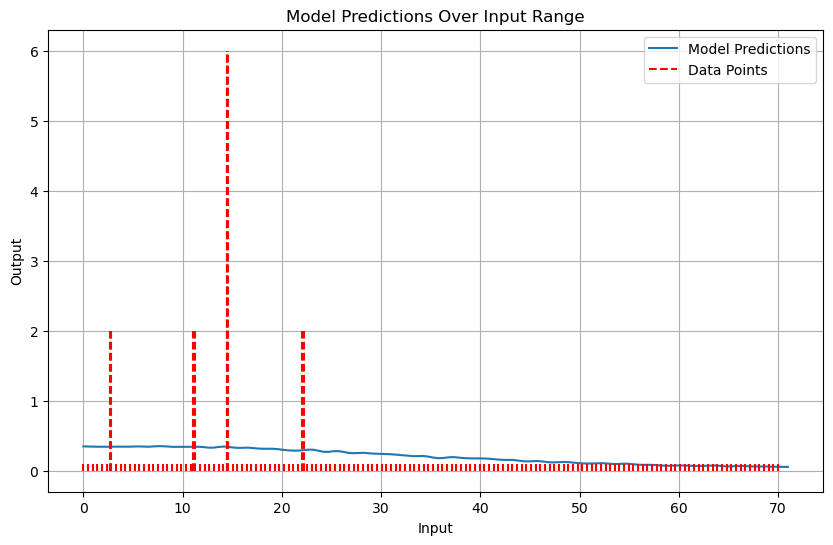

561
area: 13.178314819335936


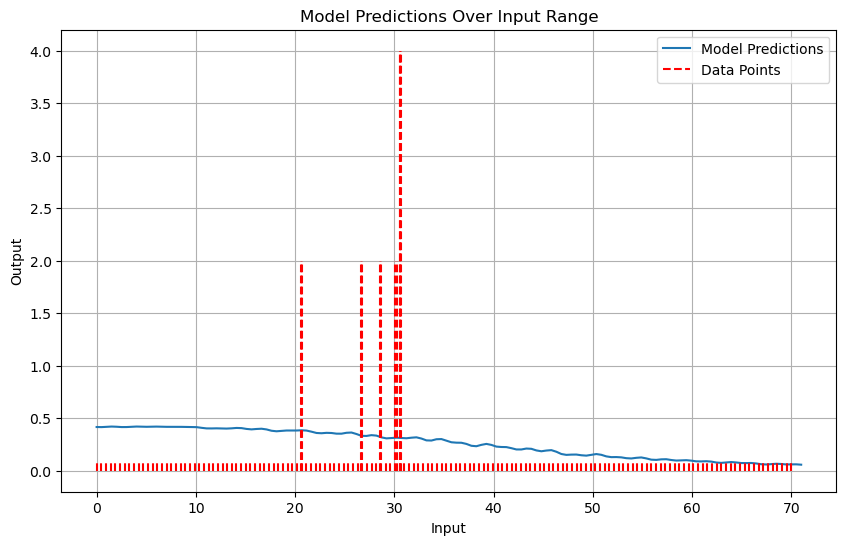

2905
area: 16.891910705566406


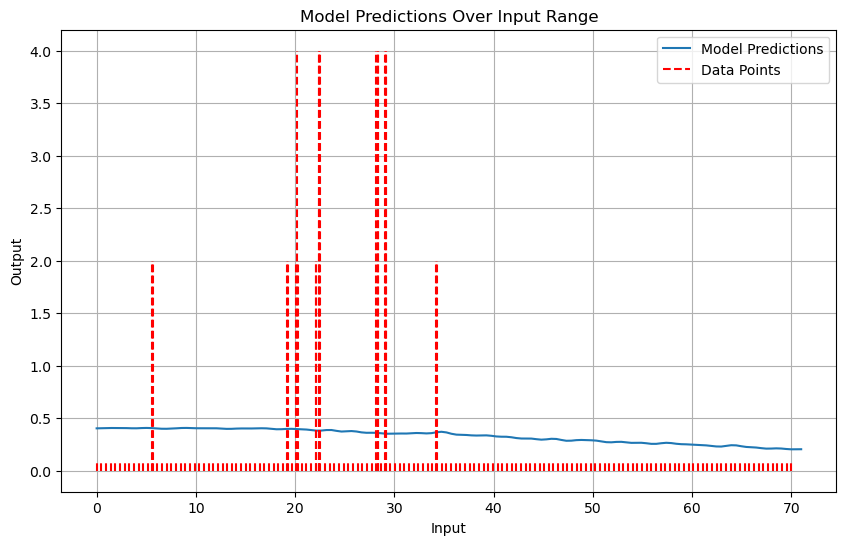

1622
area: 17.396172180175782


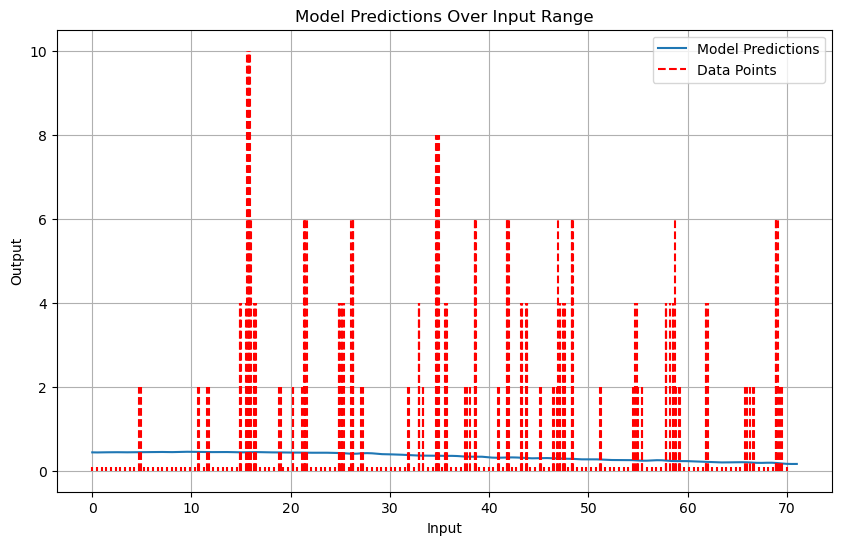

2839
area: 26.957249450683594


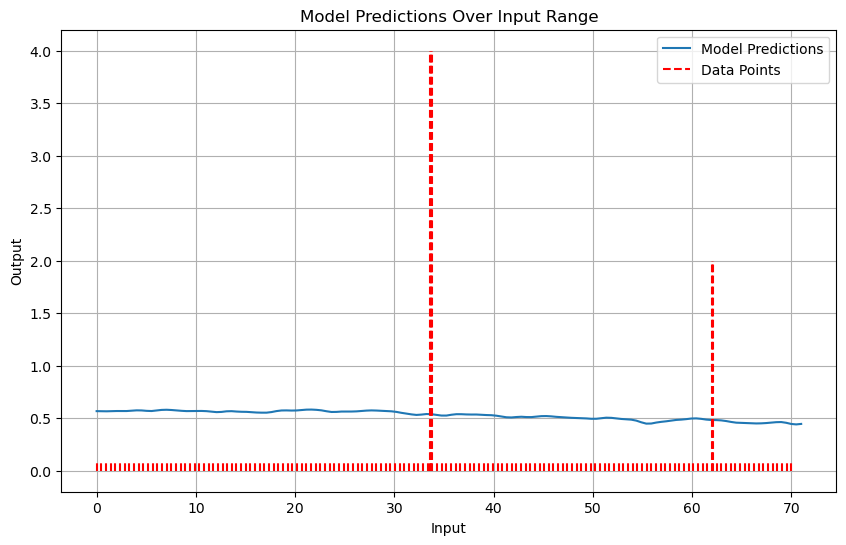

1372
area: 10.846724853515624


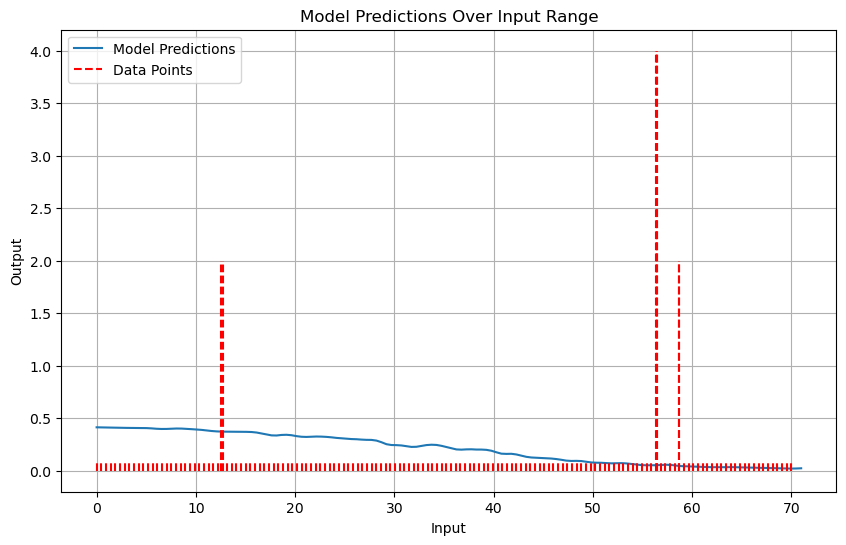

3059
area: 23.922680053710938


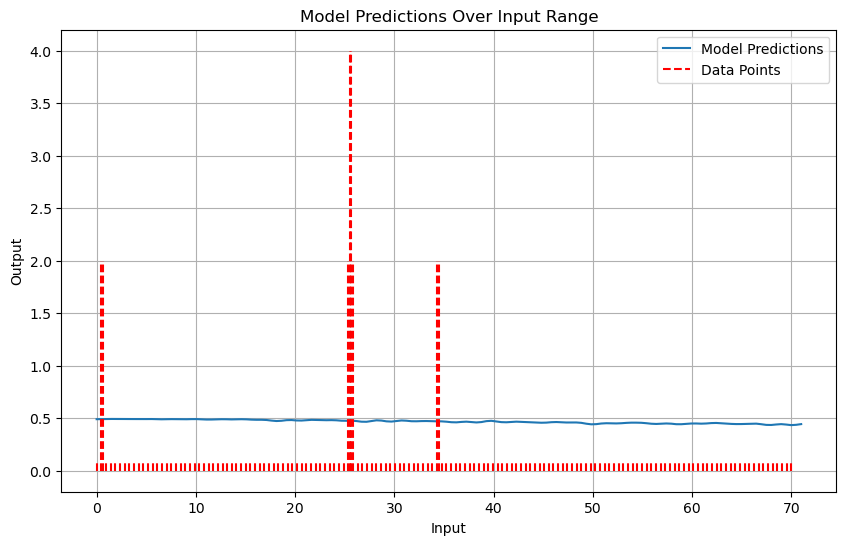

2249
area: 10.62548355102539


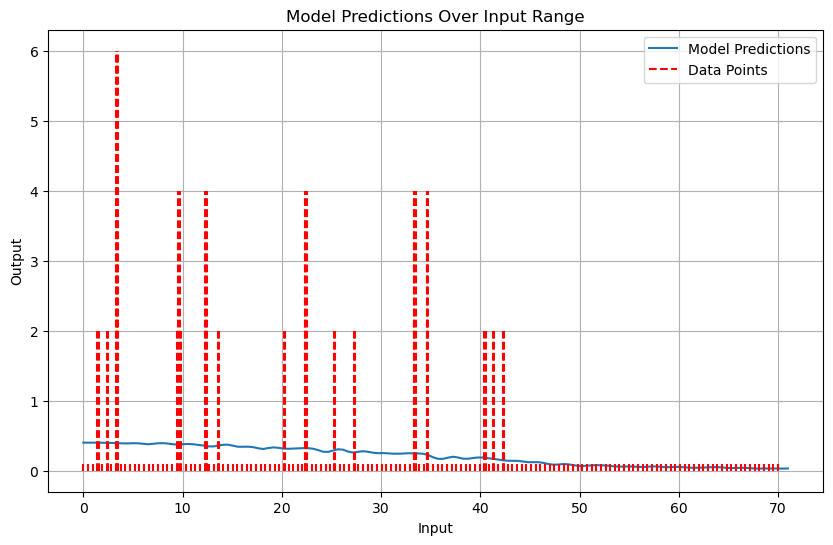

2290
area: 9.9431982421875


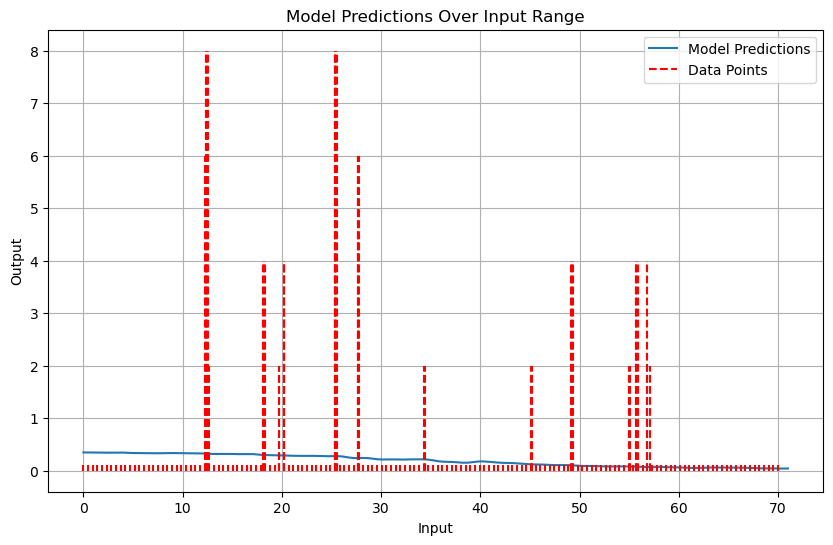

In [ ]:
for selected_user in range(len(dataloader_list)):
    utils.generate_density_plot(selected_user, model, model_type, dataloader_list, 
                    use_variational_nn=False, train_sorted=False)

800
area: 16.720106506347655


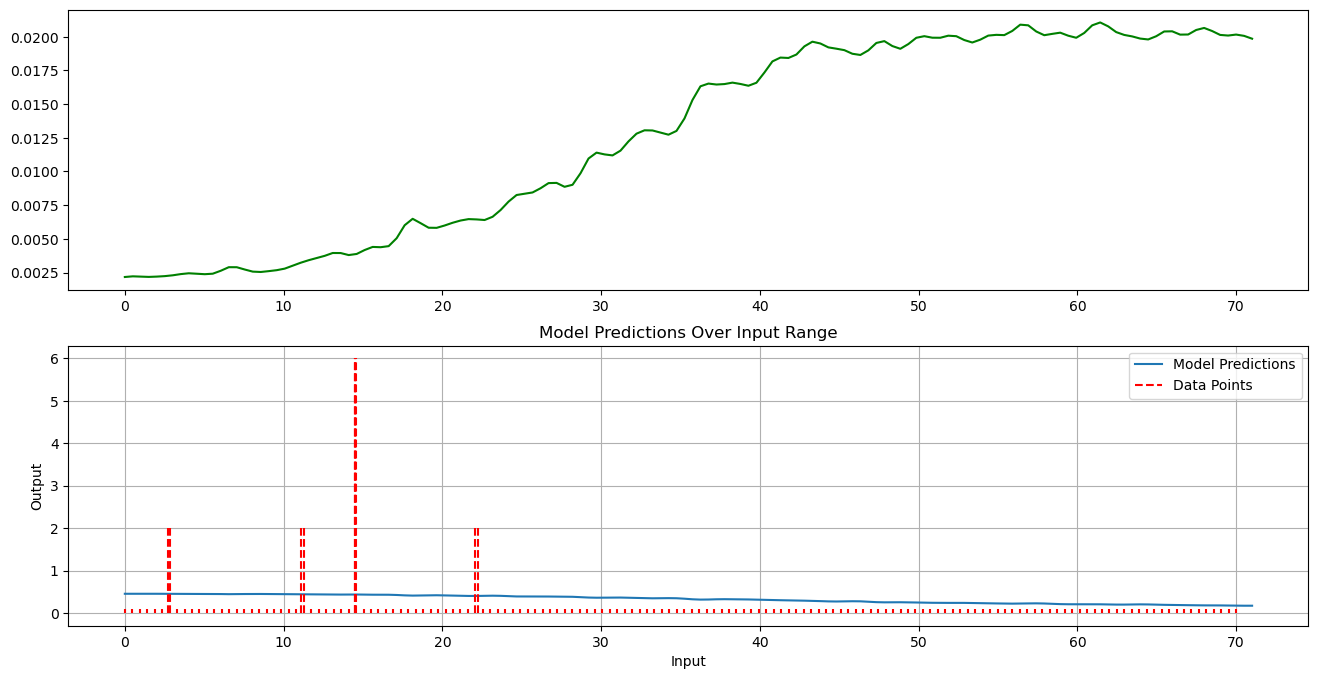

In [ ]:
# ugly version, pront variance in separate plot, is decieving
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

selected_user = 11
dataloader, variational_means, variational_logvar, extras = dataloader_list[selected_user]
print(extras["user_id"])
dataset = dataloader.dataset
x_range = np.linspace(0, 71, 71*2)  # Adjust the range as needed
x_range_tensor = torch.tensor(x_range, dtype=torch.float32).unsqueeze(1)
model.eval()
with torch.no_grad():
    if model_type == "ode":
        raise NotImplementedError
        state = torch.zeros((1, state_size))

        predictions = []
        for el in x_range:
            out = model(state, el)
            predictions.append(out[0])
    else:
        if use_variational_nn:
            predictions_list = []
            for _ in range(20):
                state = torch.tensor(variational_means).repeat(len(x_range),1)
                predictions, states = model(state, x_range_tensor, return_new_state=True)
                predictions = predictions.numpy()
                predictions_list.append(predictions)
                #print("variance of states: ", torch.var(states))
            predictions_list = np.stack(predictions_list)
            predictions = np.mean(predictions_list, axis=0)
            var = np.var(predictions_list, axis=0)
            cond = (0.1>var) | (var <.01)
            predictions = np.where(cond.any() , predictions, 0)


        else:
            state = torch.tensor(variational_means).repeat(len(x_range),1)
            predictions, states = model(state, x_range_tensor, return_new_state=True)
            predictions = predictions.numpy()
            print("variance of states: ", torch.var(states))

print(f"area: {np.sum(predictions)*(72/200)}")
# Plot the results
plt.plot(x_range, predictions, label='Model Predictions')

if use_variational_nn:
    axs[0].plot(x_range, var, label='variance', color="green")

for i in range(len(dataset)):
    sample = dataset[i]
    x_pos= sample['timestep'].item()
    height = torch.where(sample['frequency']>0, sample['frequency'], .1).item()
    plt.plot([x_pos, x_pos], [0, height], linestyle='--', color='red')

plt.plot([0, 0], [0, 0], color='red', linestyle='--', alpha=1.0, label='Data Points')

#plt.scatter(x_train.numpy(), y_train.numpy(), color='red', label='Training Data')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Model Predictions Over Input Range')
plt.legend()
plt.grid(True)
plt.show()

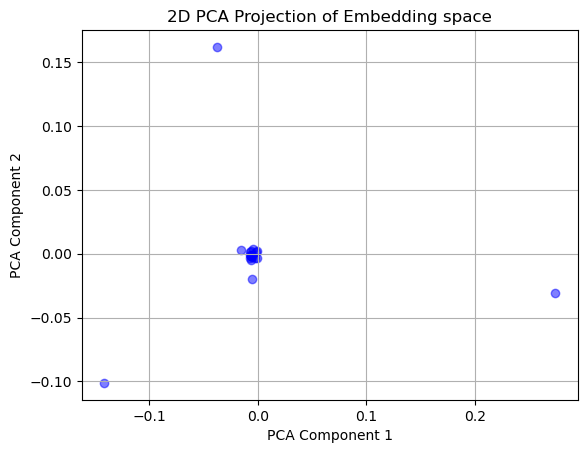

In [ ]:
#visualize embeddings
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

data = [data[1] for data in dataloader_list]

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data)

# Plot the reduced data
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c='blue', alpha=0.5)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D PCA Projection of Embedding space')
plt.grid(True)
plt.show()


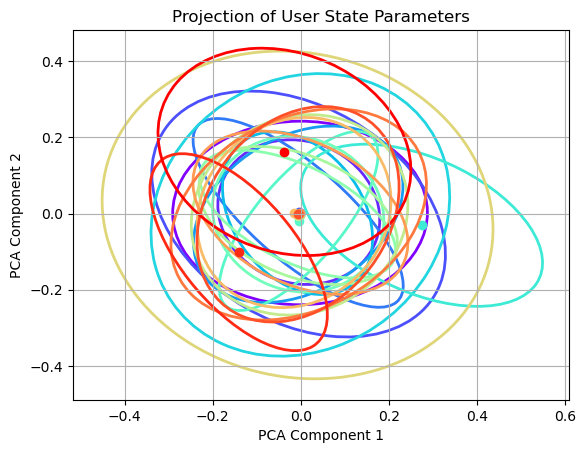

In [ ]:
#plot with variances
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.decomposition import PCA

means = [data[1] for data in dataloader_list]
covariances = [np.exp(data[2])*np.eye(state_size) for data in dataloader_list]

colors = plt.cm.rainbow(np.linspace(0, 1, len(means)))

pca = PCA(n_components=2)
reduced_means = pca.fit_transform(means)

def project_covariance(cov, pca):
    return pca.components_ @ (cov ) @ pca.components_.T

reduced_covariances = [project_covariance(cov, pca) for cov in covariances]

# Plotting
fig, ax = plt.subplots()
i =0
for mean, cov in zip(reduced_means, reduced_covariances):
    # Plot the mean
    ax.scatter(mean[0], mean[1], color=colors[i])
    
    # Calculate and plot the 2D Gaussian ellipse
    vals, vecs = np.linalg.eigh(cov)
    width, height = 2 * np.sqrt(vals)
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, 
                edgecolor=colors[i], fc='None', lw=2)
    i+=1
    ax.add_patch(ellipse)

ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_title('Projection of User State Parameters')
ax.grid(True)
plt.show()


In [ ]:
assdad

NameError: name 'assdad' is not defined

## function Approx. sampling

In [ ]:
width=64
use_jump = False
user_state_dict = {"model_hyp": {"layer_width": [width for _ in range(4)]}}
time_dict = {"model_hyp": {"layer_width": [width for _ in range(3)]}
            }
jump_dict= {"model_hyp": {"layer_width": [8, 8]}
            }

timecheat = False
hyperparameter_dict = {"state_size": state_size, "time_model": time_dict, 
                           "state_model": user_state_dict,
                           "time_embedding_size" :32, "max_freq": 30,}

if use_jump:
    hyperparameter_dict["jump_model"]= jump_dict
train_model = all_in_one_model(hyperparameter_dict, timecheat=timecheat, noise_size=1)
print(train_model)

all_in_one_model(
  (time_model): Base_Model(
    (model): Sequential(
      (0): Linear(in_features=5, out_features=64, bias=True)
      (1): SiLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): SiLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): SiLU()
      (6): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (embed): SignWaveEmbedding()
  (state_model): Base_Model(
    (model): Sequential(
      (0): Linear(in_features=37, out_features=64, bias=True)
      (1): SiLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): SiLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): SiLU()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): SiLU()
      (8): Linear(in_features=64, out_features=4, bias=True)
    )
  )
)


In [ ]:
steps_per_epoch = len(dataloader_list)

num_epochs = 201
warmup_period = steps_per_epoch * 1
num_steps = num_epochs*steps_per_epoch - warmup_period
num_iter_til_first_restart = (num_steps + 1)//2
user_lr = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

optimizer = optim.AdamW(train_model.parameters(), lr=user_lr,
                        weight_decay=1e-7)
lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=num_iter_til_first_restart, T_mult=1, eta_min=1e-6)

warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)


Using device: cpu


In [ ]:
from simtrain.utils import weighted_mse_loss

loss_func_kl=partial(utils.kl_divergence, mu2=0, sigma2=0.01)

In [ ]:
train_function_approx_multiple_variational(train_model, path_list, scoring_func=utils.energy_score_loss,
            device=device, user_lr=0.01, user_lr_decay=0.995,
            loss_func_kl=loss_func_kl, kl_weight=kl_weight, logging_shift=1,
            state_size=state_size, warmup_scheduler=warmup_scheduler, lr_scheduler=lr_scheduler,
            optimizer=optimizer, num_epochs=num_epochs, num_tries=30, timecheat=timecheat, 
            loss_print_interval=25, include_jump=use_jump,
            warmup_period=warmup_period)


  0%|          | 1/201 [00:02<07:33,  2.27s/it]


KeyboardInterrupt: 

### visualization

In [ ]:
user_id = 4
sample_path = path_list[user_id]
state = torch.tensor([sample_path[1]])
len(sample_path[0]), state, f"id: {sample_path[4]['user_id']}"

(6, tensor([[0.4029, 0.2858, 0.3668, 0.8587]]), 'id: 561')

In [ ]:
# simpler nn
simulate_single_partial_forced_function_approx = partial(
    utils.simulate_single_forced_function_approx, user_data=sample_path,state=state,
                              num_tries=100, timecheat=timecheat, state_size=state_size,
                              use_jump=use_jump)
simulate_single_partial_function_approx = partial(
    utils.simulate_single_function_approx, num_events =len(sample_path[0]), state=state,
                              num_tries=100, timecheat=timecheat, state_size=state_size,
                              jump_data=sample_path[3] if use_jump else False
                              )

In [ ]:
# intensity
example_out_forced = simulate_single_partial_forced_function_approx(train_model)
example_out = simulate_single_partial_function_approx(train_model)


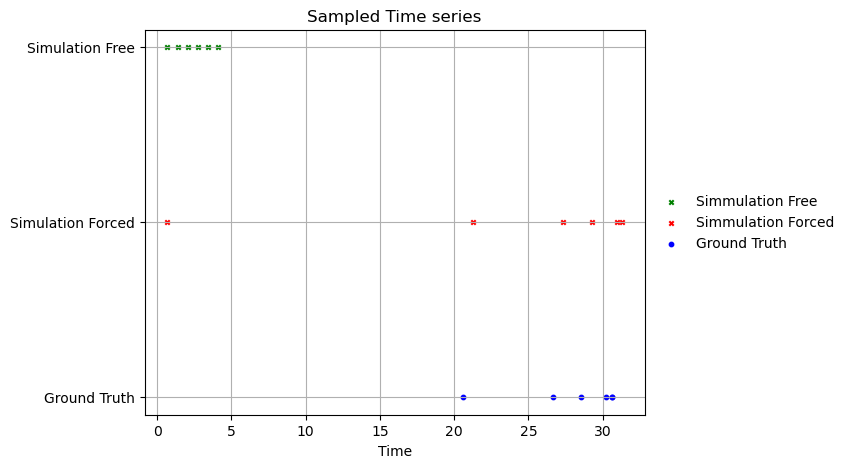

In [ ]:
time_series_1 = sample_path[0] # Timestamps for the first time series
time_series_2 = torch.clamp(torch.as_tensor(example_out_forced),0,70).detach().numpy()  # Timestamps for the second time series
time_series_3 = torch.clamp(torch.as_tensor(example_out), 0, 1000).detach().numpy()  # Timestamps for the second time series


# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(time_series_3, [3] * len(time_series_3), color='green', label='Simmulation Free', s=10, marker='x')

ax.scatter(time_series_2, [2] * len(time_series_2), color='red', label='Simmulation Forced', s=10, marker='x')

ax.scatter(time_series_1, [1] * len(time_series_1), color='blue', label='Ground Truth', s=10, marker='o')


# Add labels, legend, and grid
ax.set_xlabel('Time')
ax.set_yticks([1, 2, 3])
ax.set_yticklabels(['Ground Truth', 'Simulation Forced', "Simulation Free"])
ax.set_title('Sampled Time series')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

# Adjust subplot parameters to make room for the legend
plt.subplots_adjust(right=0.75)
ax.grid(True)

# Display the plot
plt.show()



In [ ]:
for ind in range(len(path_list)):
    utils.visualize_samples(ind,train_model, path_list, state_size, timecheat=False, 
                      use_jump=False)


2118


NameError: name 'partial' is not defined

# Combined Models old

In [16]:
# parameter dicts
width= 32
user_state_dict = {"model_hyp": {"layer_width": [width, width, width]}}
intensity_state_dict = {"model_hyp": {"user_model_hyp": {"layer_width": [width, width],
                                        "noise": 0},
                        "global_model_hyp": {"layer_width": [width, 3]}}
                            }
interaction_state_dict = {"model_hyp": {"layer_width": [width, width ,width]}
                            }
jump_state_dict = {"model_hyp": {"layer_width": [width, width]}
                        }

hyperparameter_dict = {"state_size": state_size, "state_model": user_state_dict, 
        "num_interaction_outcomes": num_interaction_types,
        "intensity_model": intensity_state_dict,# "num_recom" : num_items_per_recom,
        "recom_dim":recom_dim, "interaction_model": interaction_state_dict,
        "jump_model": jump_state_dict, "user_params_size": state_size,
        "noise": .0}
model = User_simmulation_Model(hyperparameter_dict)
#model = Conditioned_User_simmulation_Model(hyperparameter_dict)

In [17]:
# load model
path = join(paths.dat, SETTINGS.rootpaths['models'],
                 experiment_name, "user_model.h5")
#model.load_state_dict(torch.load(path))

In [18]:
num_epochs = 10
warmup_period = len(dataset)
num_steps = num_epochs*len(dataset) -warmup_period
num_iter_til_first_restart = num_steps//2
user_lr = 0.01

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

optimizer = optim.AdamW(model.parameters(), lr=0.01,
                        weight_decay=1e-7)
lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=num_iter_til_first_restart, T_mult=1, eta_min=5e-5)

warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)


Using device: cpu


In [19]:
utils.print_user_params(dataloader, print_var = True)

means:  [tensor([nan], dtype=torch.float64), tensor([nan], dtype=torch.float64), tensor([nan], dtype=torch.float64), tensor([nan], dtype=torch.float64)]
logvar:  [tensor([nan], dtype=torch.float64), tensor([nan], dtype=torch.float64), tensor([nan], dtype=torch.float64), tensor([nan], dtype=torch.float64)]
means:  [tensor([nan], dtype=torch.float64), tensor([nan], dtype=torch.float64), tensor([nan], dtype=torch.float64), tensor([nan], dtype=torch.float64)]
logvar:  [tensor([nan], dtype=torch.float64), tensor([nan], dtype=torch.float64), tensor([nan], dtype=torch.float64), tensor([nan], dtype=torch.float64)]


In [20]:
# no negative samples
#with torch.autograd.set_detect_anomaly(True):

train(model, dataloader=dataloader, num_epochs=num_epochs, device=device, 
        loss_func_kl=utils.kl_loss, kl_weight=kl_weight, user_lr=user_lr, 
        conditioned=conditioned, loss_func= nn.NLLLoss(), 
        optimizer=optimizer, lr_scheduler=lr_scheduler, num_classes=num_interaction_types, 
        logger=utils.logging_func, warmup_period=warmup_period, 
        intensity_loss_func=utils.square_intensity_loss,
        state_size=state_size,max_time=max_time, log_step_size=1, 
        warmup_scheduler = warmup_scheduler,
        )


 10%|█         | 1/10 [00:17<02:35, 17.27s/it]

loss_all: nan 	loss_base: nan 	loss_kl: nan 	loss_intensity:  nan 	log of the loss: nan


In [ ]:
adsaf 

In [ ]:
train_with_negatives(model, dataloader=dataloader, num_epochs=num_epochs, device=device, 
                loss_func=utils.loss_func, loss_func_kl=utils.kl_loss, kl_weight=kl_weight, 
                user_lr=user_lr, optimizer=optimizer, lr_scheduler=lr_scheduler, 
                num_classes=num_interaction_types, logger=utils.logging_func,
                warmup_period=warmup_period, intensity_loss_func=utils.log_loss,
                state_size=state_size,max_time=max_time, log_step_size=1, warmup_scheduler = warmup_scheduler,
                num_negatives=num_negatives, positive_examples_weight=5,conditioned=conditioned,
                )

In [ ]:
utils.print_user_params(dataloader, print_var = True)

In [ ]:
#save model
path = join(paths.dat, SETTINGS.rootpaths['models'],
                             experiment_name, "user_model.h5")

torch.save(model.state_dict(), path)

In [ ]:
# save data(changes during training)
path = join(paths.dat, SETTINGS.rootpaths['models'],
                             experiment_name, "data.h5")
torch.save({
    'data': dataloader.dataset.data,
}, path,
)


## visualize

In [ ]:
# conditioned square continouous state + state_int new formulas
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, 
                dataset=dataloader.dataset, User_model = model, use_true_recommendations =True, 
                num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=conditioned, increment=.5)

In [ ]:
# conditioned square continouous state + state_int
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=conditioned, increment=.5)

In [ ]:
# conditioned square continouous state
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=conditioned, increment=.5)

In [ ]:
# conditioned negative
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=conditioned, increment=.5)

In [ ]:
# conditioned_square
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=4, conditioned=conditioned, increment=.5)

In [ ]:
# negative sampling  larger intervals
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=4, conditioned=False, increment=.5)

In [ ]:
# square  larger intervals train longer
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=4, conditioned=False, increment=.2)

In [ ]:
# square  larger intervals
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=1, conditioned=False, increment=.2)

In [ ]:
# square continuous state integral
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=False)

In [ ]:
# negative conditioned
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=True)

In [ ]:
# square conditioned
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=True)

In [ ]:
# square
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2)

In [ ]:
#negative
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=1)